# Computer Exercise 2
#### Due date: Oct. 5 (Wed.) 23:00-2022312873李佳璇

In [441]:
# import libraries
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Experiment 1 (FLD):
#### Use TrainingSet-1 to calculate the discriminant function using FLD. Apply the discriminant function on TestSet-1. Calculate the error rate. 
### Step 1: Import training data 
#### Include data in 'train1_icu_data.csv' as trainX, and 'train1_icu_label.csv' as tarinY

In [442]:
# load trainX
trainX = []
print('For feature x:')
with open('./data1forEx1to4/train1_icu_data.csv') as xf:
    xf_csv = csv.reader(xf)
    # get headers
    headersX = next(xf_csv)
    print('-------------------------------feature counting-------------------------------------')
    print('Totally %d features' % len(headersX),'included:\n', headersX)
    # get x values
    for xrow in xf_csv:
        trainX.append(xrow)
    print('-------------------------------sample counting-------------------------------------')
    print('There are totally %d samples for training' % len(trainX))

For feature x:
-------------------------------feature counting-------------------------------------
Totally 108 features included:
 ['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_temp_max', 'h1_temp_m

In [443]:
# load trainY
trainY = []
print('For label y:')
with open('./data1forEx1to4/train1_icu_label.csv') as yf:
    yf_csv = csv.reader(yf)
    # get headers
    headersY= next(yf_csv)
    print('-------------------------------label counting-------------------------------------')
    print('Totally %d label' % len(headersY),'included:\n', headersY)
    for yrow in yf_csv:
        trainY.append(yrow)
    print('-------------------------------sample counting-------------------------------------')
    if len(trainY)==len(trainX):
        print('There are totally %d samples for training' % len(trainY), '，which has the same counting result as X')
    else:
        print('Index error: X and Y have different sample size.')

For label y:
-------------------------------label counting-------------------------------------
Totally 1 label included:
 ['hospital_death']
-------------------------------sample counting-------------------------------------
There are totally 5000 samples for training ，which has the same counting result as X


### (Extra) Normalize the data
#### As we can see that the number scope of 108 features have large difference, do a normalization here to make them have the same order of magnitude, which is good for comprehensive comparison.

In [444]:
# 0-1 normalization
AtrainX = np.array(trainX, dtype = 'float64')
def maxminNorm(arrX):
    maxi = np.max(arrX, axis=0)
    mini = np.min(arrX, axis=0)
    return (arrX-mini)/(maxi-mini)
AtrainX = maxminNorm(AtrainX)

### Step 2: Divide the feature X into two groups according to label Y
#### label Y indicate the hospital_death, wich is the classification. So using the label difference to divide X into two groups. One group of people with feature X0 with hospital_death=0, and the other group of people with feature X1 with hospital_death=1.

In [445]:
AtrainY = np.array(trainY, dtype = 'float64')
AtrainY = AtrainY.reshape(len(trainY),)
# make sure the number of 0,1 is not a string but a integer
for i in range(len(trainY)):
    AtrainY[i]=int(AtrainY[i])
# division
pos0 = np.where(AtrainY==0)
AXneg = np.squeeze(AtrainX[pos0,:])
pos1 = np.where(AtrainY==1)
AXpos = np.squeeze(AtrainX[pos1,:])
print('After division,')
print('We have a group of hospital_death(Ylabel)=0 with %d samples' %AXneg.shape[0])
print('We have a group of hospital_death(Ylabel)=1 with %d samples' %AXpos.shape[0])

After division,
We have a group of hospital_death(Ylabel)=0 with 2450 samples
We have a group of hospital_death(Ylabel)=1 with 2550 samples


### Step 3: Matrix calculation
#### Calculate within-class scatter matrix and Between-class scatter matrix for further FLD calculation

In [446]:
# calculate class mean
mean0 = np.mean(AXneg, axis=0)
mean1 = np.mean(AXpos, axis=0)
Amean0 = mean0.reshape(mean0.shape[0],1)
Amean1 = mean1.reshape(mean1.shape[0],1)
# within-class scatter matrix, S1 for class 0, S2 for class 1
S1 = np.dot((AXneg-mean0).transpose(), (AXneg-mean0))
S2 = np.dot((AXpos-mean1).transpose(), (AXpos-mean1))
Sw = S1 + S2  # (108, 108)
# between-class scatter matrix
Sb = np.dot((Amean0-Amean1), (Amean0-Amean1).transpose())  # (108, 108)

# check whether Sw is invertible
if np.linalg.det(Sw)!=0:
    print('Sw is invertible')
else:
    print('Warning!!!Sw is noninvertible')

Sw is invertible


### Step 4: Find the discriminant function
#### find 𝒘∗ using the fomular that 𝒘∗ has the same direction as Sw<sup>-1</sup>(m<sub>1</sub>-m<sub>2</sub>)
#### find 𝒘0 using the fomular that $𝒘0 = -\frac {1}{2}（\widetilde{m_1}+\widetilde{m_2}）$

In [447]:
# get 𝒘∗
W = np.dot(np.linalg.inv(Sw),(Amean0-Amean1))
Wabs = np.linalg.norm(W, axis=1, keepdims=True)
W = W/Wabs
print('𝒘∗ for discriminant function has shape ', W.shape)

# get 𝒘0
m1 = np.dot(W.transpose(), Amean0)
m2 = np.dot(W.transpose(), Amean1)
w0 = -1/2*(m1+m2)
print('w0 for discriminant function is')
print(w0)

𝒘∗ for discriminant function has shape  (108, 1)
w0 for discriminant function is
[[3.71071967]]


### Step 5: Training result

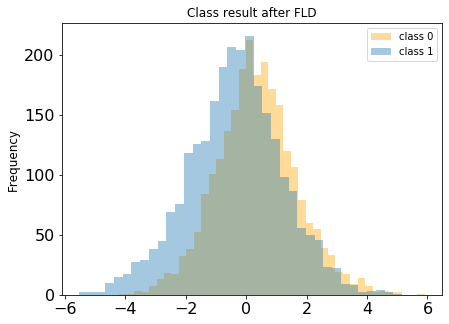

In [448]:
# result>1, class 0; result<1, class 1
classa = np.matrix(AXneg).dot(W)+w0
classb = np.matrix(AXpos).dot(W)+w0

# plot result
plt.rcParams['figure.figsize'] = (15, 5)
f = plt.figure()

f.add_subplot(1,2,1)
sns.distplot(classa, kde=False,color= "orange", label='class 0')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

f.add_subplot(1,2,1)
sns.distplot(classb,kde=False, label='class 1')
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Class result after FLD", fontsize=12)
plt.legend()
plt.show()

### Step 6: Tesing result
#### including 1) load data, 2) get test accuracy

In [449]:
# load X features
testX = []
with open('./data1forEx1to4/test1_icu_data.csv') as testxf:
    txf_csv = csv.reader(testxf)
    # get headers
    theadersX = next(txf_csv)
    # get x values
    for txrow in txf_csv:
        testX.append(xrow)
# load Y features
testY = []
with open('./data1forEx1to4/test1_icu_label.csv') as testyf:
    tyf_csv = csv.reader(testyf)
    # get headers
    theadersY= next(tyf_csv)
    for tyrow in tyf_csv:
        testY.append(tyrow)
    if len(testY)==len(testX):
        print('There are totally %d samples for testing' % len(testY))
    else:
        print('Index error: X and Y have different sample size.')
print('Test data load successfully')

There are totally 1097 samples for testing
Test data load successfully


In [450]:
# get test accuracy
AtestX = np.array(testX, dtype='float64')
AtestY = np.array(testY, dtype='float64')
AtestY = AtestY.reshape(len(testY),)

tpos0 = np.where(AtestY==0)
tAXneg = np.squeeze(AtestX[tpos0,:])
tpos1 = np.where(AtestY==1)
tAXpos = np.squeeze(AtestX[tpos1,:])

tclassa = np.matrix(tAXneg).dot(W)+w0
tclassb = np.matrix(tAXpos).dot(W)+w0

# counting
k=0
for i in range(tclassa.shape[0]):
    if tclassa[i]>0:
        k=k+1
for j in range(tclassb.shape[0]):
    if tclassb[j]<0:
        k=k+1
print('Error rate of FLD discriminant function is %.5f' % (k/len(testY)))

Error rate of FLD discriminant function is 0.49863


### Conclusion of Experiment 1 (FLD)
#### During experiment 1, the steps for calculate the discriminant function using FLD are:
1) Import training data and normalization <br>
2) Divide the feature X into two groups according to label Y <br>
3) Calculate the (a) within-class scatter matrix and (b) between-class scatter matrix <br>
4) Using formula (a) 𝒘∗∝Sw<sup>-1</sup>(m<sub>1</sub>-m<sub>2</sub> and (b) $𝒘0 = -\frac {1}{2} \widetilde{m_1}+\widetilde{m_2}）$ to calculate discriminant function <br>
5) And I also add a visible plot of the discriminant function result for training data <br>
#### The steps for applying the discriminant function on TestSet-1 calculate the error rate are:
1) load data <br>
2) get error rate, which is $e={k\over N}$=0.4986, where k is thenumber of error and N is the number of testing samples. 
#### The result shows that FLD result is not good. 

In [451]:
# As the requirment says "Find public packages for Perceptron and Logistic Regression (LR)"
# import more libraries
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

## Experiment 2 (Perceptron):
#### 1) Use TrainingSet-1 to train the Perceptron classifier. Calculate the training error and cross validation error on the training set. Apply the trained Perceptron to TestSet-1. Compare the training error rate, cross-validation error rate and test error rate.
#### 2) Use TrainingSet-2 to train the Perceptron classifier. Apply the Perceptron trained with TrainingSet-2 to TestSet-1 and TestSet-2, respectively. Compare the error rates.
#### 3) Discuss your observations on the results.

## 1）Use TrainingSet-1 to train the Perceptron classifier.
### Step 1: Import data 
#### Include training data in 'train1_icu_data.csv' as train1X, and 'train1_icu_label.csv' as tarin1Y
#### And testing data in  'test1_icu_data.csv' as test1X, and 'test1_icu_label.csv' as test1Y

In [452]:
# load trainX
train1X = []
print('For feature x:')
with open('./data1forEx1to4/train1_icu_data.csv') as x1f:
    x1f_csv = csv.reader(x1f)
    # get headers
    headers1X = next(x1f_csv)
    print('-------------------------------feature counting-------------------------------------')
    print('Totally %d features' % len(headers1X))
    # get x values
    for x1row in x1f_csv:
        train1X.append(x1row)
    print('-------------------------------sample counting-------------------------------------')
    print('There are totally %d samples for training' % len(train1X))

For feature x:
-------------------------------feature counting-------------------------------------
Totally 108 features
-------------------------------sample counting-------------------------------------
There are totally 5000 samples for training


In [453]:
# load trainY
train1Y = []
print('For label y:')
with open('./data1forEx1to4/train1_icu_label.csv') as y1f:
    y1f_csv = csv.reader(y1f)
    # get headers
    headers1Y= next(y1f_csv)
    print('-------------------------------label counting-------------------------------------')
    print('Totally %d label' % len(headers1Y),'included:\n', headers1Y)
    for y1row in y1f_csv:
        train1Y.append(y1row)
    print('-------------------------------sample counting-------------------------------------')
    if len(train1Y)==len(train1X):
        print('There are totally %d samples for training' % len(train1Y), '，which has the same counting result as X')
    else:
        print('Index error: X and Y have different sample size.')

For label y:
-------------------------------label counting-------------------------------------
Totally 1 label included:
 ['hospital_death']
-------------------------------sample counting-------------------------------------
There are totally 5000 samples for training ，which has the same counting result as X


In [454]:
# load test data
# load X features
test1X = []
with open('./data1forEx1to4/test1_icu_data.csv') as test1xf:
    t1xf_csv = csv.reader(test1xf)
    # get headers
    theaders1X = next(t1xf_csv)
    # get X values
    for t1xrow in t1xf_csv:
        test1X.append(t1xrow)
# load Y features
test1Y = []
with open('./data1forEx1to4/test1_icu_label.csv') as test1yf:
    t1yf_csv = csv.reader(test1yf)
    # get headers
    theaders1Y= next(t1yf_csv)
    # get Y value
    for t1yrow in t1yf_csv:
        test1Y.append(t1yrow)
    if len(test1Y)==len(test1X):
        print('There are totally %d samples for testing' % len(test1Y))
    else:
        print('Index error: X and Y have different sample size.')
print('Test data load successfully')

There are totally 1097 samples for testing
Test data load successfully


### Step 2: Define and train a Perceptron
#### Train a Perceptron model with TrainingSet-1

In [455]:
# define a Perceptron
clf1 = Perceptron(fit_intercept=True, max_iter=10, shuffle=False)
# train a Perceptron
Atrain1X = np.array(train1X, dtype = 'float64')
Atrain1Y = np.array(train1Y, dtype = 'float64')
clf1.fit(train1X, train1Y)
# training result of w* and b
W1 = clf1.coef_[0]
b1 = clf1.intercept_

### Step 3: Define a errorRate function to calculate error rate for both training and testing data

In [456]:
# define error rate equation
def errorRate(X, Y, w, b):
    error = 0
    w = w.reshape(w.shape[0],1)
    yPred = np.matrix(X).dot(w)+b
    yPred = np.sign(yPred)
    tpos0 = np.where(Y==0)
    tpos0 = np.array(tpos0)
    tpos1 = np.where(Y==1)
    tpos1 = np.array(tpos1)
    for i in range(tpos0.shape[1]):
        if yPred[tpos0[0][i]] != -1:
            error = error + 1
    for j in range(tpos1.shape[1]):
        if yPred[tpos1[0][j]] != 1:
            error = error + 1
    return error/X.shape[0]

### Step 4: Calculate training error rate, cross-validation error and test error rate
#### Calculate the three value independently in three code blocks

In [457]:
# calculate training error rate
trainError = errorRate(Atrain1X, Atrain1Y, W1, b1)
print('Training error rate:')
print('Error rate of Perceptron trained by TrainingSet-1 is %.5f' %trainError)

Training error rate:
Error rate of Perceptron trained by TrainingSet-1 is 0.27300


In [458]:
# cross validation
Atrain1X = np.array(train1X, dtype = 'float64')
Atrain1Y = np.array(train1Y, dtype = 'float64')
Atrain1Y = Atrain1Y.reshape(len(train1Y),)
# make sure the number of 0,1 is not a string but a integer
for i in range(len(train1Y)):
    Atrain1Y[i]=int(Atrain1Y[i])
scores = cross_val_score(clf1, Atrain1X, Atrain1Y, cv=10, scoring='accuracy')
errorMean = 1-np.mean(scores)
print('There are totally 10-fold cross validation, cross validation scores are ', scores, 'independently')
print('Therefore, the mean cross validation error is %.5f' % errorMean)

There are totally 10-fold cross validation, cross validation scores are  [0.642 0.624 0.554 0.652 0.75  0.71  0.576 0.744 0.668 0.51 ] independently
Therefore, the mean cross validation error is 0.35700


In [459]:
# calculate testing error rate
Atest1X = np.array(test1X, dtype = 'float64')
Atest1Y = np.array(test1Y, dtype = 'float64')
for i in range(len(test1Y)):
    Atest1Y[i][0]=int(Atest1Y[i][0])
testError = errorRate(Atest1X, Atest1Y, W1, b1)
print('Testing error rate:')
print('Error rate of Perceptron trained by TrainingSet-1 is %.5f' %testError)

Testing error rate:
Error rate of Perceptron trained by TrainingSet-1 is 0.27803


### Conclusion
#### The training error rate is 0.27300, cross validation error is 0.35700, and testing error rate is 0.27803
#### We can see that the error rates in training set and testing set are almost the same (training is slightly lower than testing), which means the classifier has a good generalization performance. <br>And cross validation error is and approximation of testing error rate based on training data, but here maybe because when divided the training data into 10 groups, the amount training data decrease, so the value is higher than the other two.

## 2）Use TrainingSet-2 to train the Perceptron classifier.
### Step 1: Import data 
#### Include data in 'train2_icu_data.csv' as train2X, and 'train2_icu_label.csv' as tarin2Y
#### And  testing data in 'test2_icu_data.csv' as test2X, and 'test2_icu_label.csv' as test2Y

In [460]:
# load trainX
train2X = []
print('For feature x:')
with open('./data1forEx1to4/train2_icu_data.csv') as x2f:
    x2f_csv = csv.reader(x2f)
    # get headers
    headers2X = next(x2f_csv)
    print('-------------------------------feature counting-------------------------------------')
    print('Totally %d features' % len(headers2X))
    # get x values
    for x2row in x2f_csv:
        train2X.append(x2row)
    print('-------------------------------sample counting-------------------------------------')
    print('There are totally %d samples for training' % len(train2X))

For feature x:
-------------------------------feature counting-------------------------------------
Totally 108 features
-------------------------------sample counting-------------------------------------
There are totally 1475 samples for training


In [461]:
# load trainY
train2Y = []
print('For label y:')
with open('./data1forEx1to4/train2_icu_label.csv') as y2f:
    y2f_csv = csv.reader(y2f)
    # get headers
    headers2Y= next(y2f_csv)
    print('-------------------------------label counting-------------------------------------')
    print('Totally %d label' % len(headers2Y),'included:\n', headers2Y)
    for y2row in y2f_csv:
        train2Y.append(y2row)
    print('-------------------------------sample counting-------------------------------------')
    if len(train2Y)==len(train2X):
        print('There are totally %d samples for training' % len(train2Y), '，which has the same counting result as X')
    else:
        print('Index error: X and Y have different sample size.')

For label y:
-------------------------------label counting-------------------------------------
Totally 1 label included:
 ['hospital_death']
-------------------------------sample counting-------------------------------------
There are totally 1475 samples for training ，which has the same counting result as X


In [462]:
# load test data
# load X features
test2X = []
with open('./data1forEx1to4/test2_icu_data.csv') as test2xf:
    t2xf_csv = csv.reader(test2xf)
    # get headers
    theaders2X = next(t2xf_csv)
    # get X values
    for t2xrow in t2xf_csv:
        test2X.append(t2xrow)
# load Y features
test2Y = []
with open('./data1forEx1to4/test2_icu_label.csv') as test2yf:
    t2yf_csv = csv.reader(test2yf)
    # get headers
    theaders2Y= next(t2yf_csv)
    # get Y value
    for t2yrow in t2yf_csv:
        test2Y.append(t2yrow)
    if len(test2Y)==len(test2X):
        print('There are totally %d samples for testing' % len(test2Y))
    else:
        print('Index error: X and Y have different sample size.')
print('Test data load successfully')

There are totally 450 samples for testing
Test data load successfully


### Step 2: Define and train a Perceptron
#### Train a Perceptron model with TrainingSet-2

In [463]:
# define a Perceptron
clf2 = Perceptron(fit_intercept=True, max_iter=10, shuffle=False)
# train a Perceptron
Atrain2X = np.array(train2X, dtype = 'float64')
Atrain2Y = np.array(train2Y, dtype = 'float64')
clf2.fit(train2X, train2Y)
# training result of w* and b
W2 = clf2.coef_[0]
b2 = clf2.intercept_

### Step 3: Define a errorRate function to calculate error rate for both training and testing data

In [464]:
# define error rate equation
def errorRate(X, Y, w, b):
    error = 0
    w = w.reshape(w.shape[0],1)
    yPred = np.matrix(X).dot(w)+b
    yPred = np.sign(yPred)
    tpos0 = np.where(Y==0)
    tpos0 = np.array(tpos0)
    tpos1 = np.where(Y==1)
    tpos1 = np.array(tpos1)
    for i in range(tpos0.shape[1]):
        if yPred[tpos0[0][i]] != -1:
            error = error + 1
    for j in range(tpos1.shape[1]):
        if yPred[tpos1[0][j]] != 1:
            error = error + 1
    return error/X.shape[0]

### Step 4: Calculate training error rate, cross-validation error and test error rate
#### Calculate the three value independently in three code blocks

In [465]:
# calculate training error rate
trainError2 = errorRate(Atrain2X, Atrain2Y, W2, b2)
print('Training error rate:')
print('Error rate of Perceptron trained by TrainingSet-1 is %.5f' %trainError2)

Training error rate:
Error rate of Perceptron trained by TrainingSet-1 is 0.19458


In [466]:
# cross validation
Atrain2X = np.array(train2X, dtype = 'float64')
Atrain2Y = np.array(train2Y, dtype = 'float64')
Atrain2Y = Atrain2Y.reshape(len(train2Y),)
# make sure the number of 0,1 is not a string but a integer
for i in range(len(train2Y)):
    Atrain2Y[i]=int(Atrain2Y[i])
scores2 = cross_val_score(clf2, Atrain2X, Atrain2Y, cv=10, scoring='accuracy')
errorMean2 = 1-np.mean(scores2)
print('There are totally 10-fold cross validation, cross validation scores are ', scores2, 'independently')
print('Therefore, the mean cross validation error is %.5f' % errorMean2)

There are totally 10-fold cross validation, cross validation scores are  [0.87248322 0.84563758 0.81081081 0.76870748 0.80952381 0.7755102
 0.79591837 0.78911565 0.80952381 0.72789116] independently
Therefore, the mean cross validation error is 0.19949


In [467]:
# calculate testing error rate
Atest2X = np.array(test2X, dtype = 'float64')
Atest2Y = np.array(test2Y, dtype = 'float64')
for i in range(len(test2Y)):
    Atest2Y[i][0]=int(Atest2Y[i][0])
testError2 = errorRate(Atest2X, Atest2Y, W2, b2)
print('Testing error rate:')
print('Error rate of Perceptron trained by TrainingSet-1 is %.5f' %testError2)

Testing error rate:
Error rate of Perceptron trained by TrainingSet-1 is 0.23778


### Conclusion
#### The training error rate is 0.19458, cross validation error is 0.19949, and testing error rate is 0.23778
#### We can see that the error rates in training set and cross validation error are almost the same (training is slightly lower than cross validation), which means the classifier has a good generalization performance see from the 0.005 difference. <br>But the testing error is higher than the other two by approximately 0.038, which means the classifier is still a little bit weak on the data that haven't seen before.

## 3）Discuss observations on the results
#### The result shows that the error rates onTrainingSet-2 are smaller than that on TrainingSet-1. <br>As Perceptron shows different error rate on different datasets, it proves that TrainingSet-2 is better than TrainingSet-1, when doing the classification of 'hospital_death'. For training, TrainingSet-2 performs better.

## Experiment 3 (LR):
#### 1) Use TrainingSet-1 to train the classifier with Logistic Regression. Calculate the training error and cross validation error on the training set. Apply the trained classifier on TestSet-1. Calculate the test error.
#### 2) Using Python package matplotlib to draw the ROC curve according to the test results.
#### 3) Analyze the significance of association between each feature and patients’ survival. You may need to study some materials beyond the course content by yourself (hints: you may refer to available Python packages like statsmodels).
## 1）Use TrainingSet-1 to train the classifier with Logistic Regression.
### Step 1: Import data 
#### Include training data in 'train1_icu_data.csv' as train1X, and 'train1_icu_label.csv' as tarin1Y
#### And testing data in  'test1_icu_data.csv' as test1X, and 'test1_icu_label.csv' as test1Y

In [468]:
print('Training data:')
# load trainX
train1X = []
print('For feature x:')
with open('./data1forEx1to4/train1_icu_data.csv') as x1f:
    x1f_csv = csv.reader(x1f)
    # get headers
    headers1X = next(x1f_csv)
    print('-------------------------------feature counting-------------------------------------')
    print('Totally %d features' % len(headers1X))
    # get x values
    for x1row in x1f_csv:
        train1X.append(x1row)
    print('-------------------------------sample counting-------------------------------------')
    print('There are totally %d samples for training' % len(train1X))
# load trainY
train1Y = []
print('For label y:')
with open('./data1forEx1to4/train1_icu_label.csv') as y1f:
    y1f_csv = csv.reader(y1f)
    # get headers
    headers1Y= next(y1f_csv)
    print('-------------------------------label counting-------------------------------------')
    print('Totally %d label' % len(headers1Y),'included:\n', headers1Y)
    for y1row in y1f_csv:
        train1Y.append(y1row)
    print('-------------------------------sample counting-------------------------------------')
    if len(train1Y)==len(train1X):
        print('There are totally %d samples for training' % len(train1Y), '，which has the same counting result as X')
    else:
        print('Index error: X and Y have different sample size.')
Atrain1X = np.array(train1X, dtype = 'float64')
Atrain1Y = np.array(train1Y, dtype = 'float64')
Atrain1Y = Atrain1Y.reshape(len(train1Y),)
# make sure the number of 0,1 is not a string but a integer
for i in range(len(train1Y)):
    Atrain1Y[i]=int(Atrain1Y[i])

Training data:
For feature x:
-------------------------------feature counting-------------------------------------
Totally 108 features
-------------------------------sample counting-------------------------------------
There are totally 5000 samples for training
For label y:
-------------------------------label counting-------------------------------------
Totally 1 label included:
 ['hospital_death']
-------------------------------sample counting-------------------------------------
There are totally 5000 samples for training ，which has the same counting result as X


In [469]:
print('Testing data:')
# load test data
# load X features
test1X = []
with open('./data1forEx1to4/test1_icu_data.csv') as test1xf:
    t1xf_csv = csv.reader(test1xf)
    # get headers
    theaders1X = next(t1xf_csv)
    # get X values
    for t1xrow in t1xf_csv:
        test1X.append(t1xrow)
# load Y features
test1Y = []
with open('./data1forEx1to4/test1_icu_label.csv') as test1yf:
    t1yf_csv = csv.reader(test1yf)
    # get headers
    theaders1Y= next(t1yf_csv)
    # get Y value
    for t1yrow in t1yf_csv:
        test1Y.append(t1yrow)
    if len(test1Y)==len(test1X):
        print('There are totally %d samples for testing' % len(test1Y))
    else:
        print('Index error: X and Y have different sample size.')
print('Test data load successfully')
Atest1X = np.array(test1X, dtype = 'float64')
Atest1Y = np.array(test1Y, dtype = 'float64')
for i in range(len(test1Y)):
    Atest1Y[i][0]=int(Atest1Y[i][0])

Testing data:
There are totally 1097 samples for testing
Test data load successfully


### Step 2: Define and train a classifier with Logistic Regression
#### Train a classifier with TrainingSet-1

In [470]:
# train a classifier lr
lr = LogisticRegression()
lr.fit(Atrain1X, Atrain1Y)
Wl = lr.coef_
bl = lr.intercept_

### Step 3: Calculate training error rate, cross-validation error and test error rate
#### Calculate the three value independently in three code blocks

In [471]:
# training error
sore1 = lr.score(Atrain1X, Atrain1Y)
print('-------------------------------Training-------------------------------------')
print('Training score is ', sore1)
print('So, training error is %.5f ' %(1-sore1))

# cross validation
scoreslr = cross_val_score(lr, Atrain1X, Atrain1Y, cv=10, scoring='accuracy')
errorMeanlr = 1-np.mean(scoreslr)
print('-------------------------------Cross validation-------------------------------------')
print('There are totally 10-fold cross validation, cross validation scores are ', scoreslr, 'independently')
print('Therefore, the mean cross validation error is %.5f' % errorMeanlr)

# testing error
sore2 = lr.score(Atest1X, Atest1Y)
print('-------------------------------Testing-------------------------------------')
print('Testing score is %.5f' %sore2)
print('So, testing error is %.5f' %(1-sore2))

-------------------------------Training-------------------------------------
Training score is  0.7962
So, training error is 0.20380 
-------------------------------Cross validation-------------------------------------
There are totally 10-fold cross validation, cross validation scores are  [0.794 0.764 0.802 0.768 0.822 0.804 0.778 0.794 0.76  0.786] independently
Therefore, the mean cross validation error is 0.21280
-------------------------------Testing-------------------------------------
Testing score is 0.78760
So, testing error is 0.21240


## 2) Draw the ROC curve according to the test results

Area Under ROC Curve is 0.79


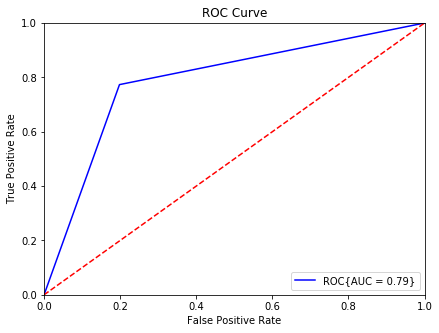

In [472]:
# do prediction and calculation
pre_result = lr.predict(Atest1X)
fpr, tpr, threshold = roc_curve(Atest1Y, pre_result)
rocauc = auc(fpr, tpr)
print('Area Under ROC Curve is %0.2f' % rocauc)

# draw ROC curve and show calculation result
plt.rcParams['figure.figsize'] = (15, 5)
f = plt.figure()
f.add_subplot(1,2,1)
plt.plot(fpr, tpr, 'b', label='ROC{AUC = %0.2f}' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3) Analyze the significance of association between each feature and patients’ survival
#### Using the principle of  <strong>*covariance*</strong>, that the larger the absolute value of the covariance, the more the two variance affect each other. (positive covariance means positive effect, while negative covariance means negative effect)

In [473]:
covList = []
for i in range(AtrainX.shape[1]):
    covList.append(np.cov(AtrainX[:,i],AtrainY)[1][0])

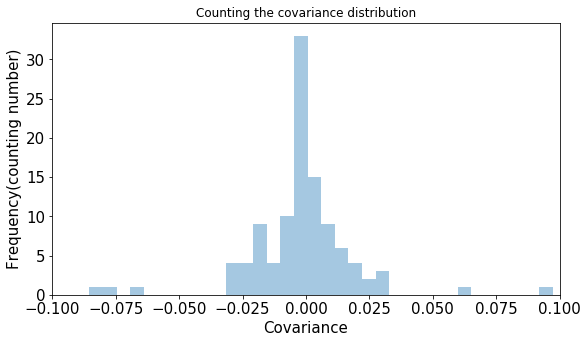

In [474]:
# counte and plot counting result
plt.rcParams['figure.figsize'] = (20, 5)
f = plt.figure()
f.add_subplot(1,2,1)
sns.distplot(covList, kde=False, label='counting')
plt.xlim([-0.1, 0.1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Counting the covariance distribution')
plt.ylabel('Frequency(counting number)',fontsize=15)
plt.xlabel('Covariance',fontsize=15)
plt.show()

In [475]:
# significance of association
pprop = []
nprop = []
for i in range(len(covList)):
    if covList[i]>0.05:
        pprop.append(headers1X[i])
    elif covList[i]<-0.05:
        nprop.append(headers1X[i])
print('From the plot above, we can see that most of the features only have small correlation with patients\' survival.')
print('But there are still some features with significant influence')
print('-------------------------------significant influence-------------------------------------')
print('There are %d features has high positive correlation with final result:' %len(pprop))
print(pprop)
print('There are %d features has high negative correlation with final result:' %len(nprop))
print(nprop)

From the plot above, we can see that most of the features only have small correlation with patients' survival.
But there are still some features with significant influence
-------------------------------significant influence-------------------------------------
There are 2 features has high positive correlation with final result:
['intubated_apache', 'ventilated_apache']
There are 3 features has high negative correlation with final result:
['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']


## Conclusion
All the analysis located after each code blocks.
During my running time, the code works good. If there are some problems, please contact me (weChat and Phone: 17353231760) 